# Phase II: Data Curation, Exploratory Analysis and Plotting
## Stock Market Predictor

### Names: Diego Cicotoste, Ariv Ahuja, 

# Introduction 

How does the stock market work? how can you predict the stock market? what tools can you use? The stock market can seem complex and unpredictable, some would even say gambeling. One of the hardest challenges is making educated or informed decisions. The goal of this project is to tackle the uncertainty and help, stock traders make better decision on wether a stock is tradable or not. Wether to buy or sell. I would use past historical trends to make educated predictions on how the stock market would react.

### **1. Data Retrieval**  
- We used the **`yfinance` API** to retrieve daily historical **Open, High, Low, Close (OHLC)** prices and **volume data** for **S&P 500 stocks**, focusing on **Amazon (AMZN)** for the **past year**.
- The retrieved data includes essential market metrics that will serve as the foundation for feature engineering.

---

### **2. Data Cleaning and Processing**

#### **Handling Missing Data**  
- No data was missing after inspection

#### **Feature Engineering: Technical Indicators**  
We calculated several key **technical indicators** to enrich the dataset:
  - **RSI (Relative Strength Index)**: Momentum indicator over 14 days.
  - **VWAP (Volume Weighted Average Price)**: Measures the average trading price weighted by volume.
  - **EMA (Exponential Moving Average)**: Captures the smoothed trend over 20 days.
  - **ADX (Average Directional Index)**: Quantifies trend strength.

#### **More Features: Sentiment Analysis from News Articles**  
- We fetched relevant **news articles** using **NewsAPI** for the same period as the stock data.
- **VADER Sentiment Analysis** was used to calculate **compound sentiment scores** for each article.
- Sentiment scores were **aggregated by date** to align with the stock OHLC data.

#### **Data Alignment and Merging**  
- We ensured **alignment** between **OHLC data, technical indicators, log returns, and sentiment scores** using date-based indices.
- The combined DataFrame was prepared, with all relevant features available for further analysis and modeling.

---

### **3. Visualization of the Cleaned Data**

We visualized the **cleaned and processed dataset** to understand key trends and patterns:

1. **Price Trends and Indicators**:
   - **OHLC Candlestick Plots**: Show stock price movements.
   - **Overlaying VWAP and EMA**: To track trends and identify support/resistance levels.
   - **RSI and ADX Line Plots**: Visualize momentum and trend strength over time.

2. **Volume Analysis**:
   - **Normalized Volume**: Visualized to detect significant changes in trading activity.

3. **Sentiment Trends**:
   - **Sentiment Score Line Chart**: Displays how public sentiment fluctuates over time.
   - **Overlay of Sentiment with Stock Price**: To observe correlations between sentiment and price movements.


In [72]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol: str, period: str, interval: str = '1d') -> pd.DataFrame:
    """
    Retrieve stock price data for a given symbol, time period, and interval.
    Returns the stock prices as a pandas DataFrame.

    Parameters:
        symbol (str): The ticker symbol of the stock (e.g., 'AAPL').
        period (str): The period to retrieve data (e.g., '1y', '6mo', '5d').
        interval (str): The data interval (e.g., '1d', '1wk', '1mo').

    Returns:
        pd.DataFrame: DataFrame containing historical stock prices.
    """
    # Fetch data from Yahoo Finance
    stock_data = yf.download(symbol, period=period, interval=interval)

    if stock_data.empty:
        print(f"No data found for {symbol}.")
        return None

    return stock_data

In [73]:
import numpy as np

def calculate_log_returns(close: np.ndarray) -> np.ndarray:
    """
    Calculate the log returns from the close prices.
    
    Parameters:
        close (np.ndarray): Array of closing prices.
    
    Returns:
        np.ndarray: Array of log returns.
    """
    log_returns = np.log(close / close.shift(1))
    return log_returns


In [74]:
import pandas_ta as ta

def calculate_technical_indicators(df: pd.DataFrame) -> dict:
    """
    Calculate technical indicators and return them as NumPy arrays.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical stock prices.

    Returns:
        dict: A dictionary with technical indicators as NumPy arrays.
    """
    indicators = {}

    # Calculate RSI (Relative Strength Index)
    indicators['rsi'] = ta.rsi(df['Close'], length=20).to_numpy()

    # Calculate 20-day Exponential Moving Average (EMA)
    indicators['ema'] = ta.ema(df['Close'], length=20).to_numpy()

    # Calculate ADX (Average Directional Index)
    adx_df = ta.adx(df['High'], df['Low'], df['Close'], length=20)
    indicators['adx'] = adx_df['ADX_20'].to_numpy()

    # Calculate VWAP (Volume Weighted Average Price)
    vwap_series = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    indicators['vwap'] = vwap_series.to_numpy()

    # Calculate normalized volume
    indicators['normalized_volume'] = (df['Volume'] / df['Volume'].rolling(window=20).mean()).to_numpy()

    return indicators

In [80]:
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time

def get_latest_news_yahoo(stock: str) -> list:
    """
    Fetch the latest news articles from Yahoo Finance for the given stock.

    Parameters:
        stock (str): Stock symbol (e.g., 'AMZN')

    Returns:
        list: A list of dictionaries containing 'title', 'description', and 'date' for each article.
    """
    base_url = f"https://finance.yahoo.com/quote/{stock.upper()}/news?p={stock.upper()}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    articles = []
    page = 0

    while len(articles) < 500:
        url = f"{base_url}&offset={page * 20}&count=20"
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        news_items = soup.find_all('li', class_='stream-item story-item yf-1usaaz9')

        if not news_items:
            break  

        for item in news_items:
            title_tag = item.find('h3')
            if title_tag:
                title = title_tag.text.strip()
            else:
                title = ""

            description_tag = item.find('p')
            if description_tag:
                description = description_tag.text.strip()
            else:
                description = ""

            date_tag = item.find('time')
            if date_tag:
                date = date_tag['datetime'].split('T')[0]
            else:
                date = ""

            articles.append({
                'title': title,
                'description': description,
                'date': date
            })

            if len(articles) >= 500:
                break

        page += 1
        time.sleep(0.75) 
        print(len(articles))

    return articles


[]


In [76]:
from textblob import TextBlob

def add_sentiment_scores_to_articles(articles: list) -> list:
    """
    Add sentiment scores to the provided list of articles using TextBlob.
    
    Parameters:
        articles (list): A list of dictionaries where each dictionary contains article information 
                         like 'title' and optionally 'description'.
                         
    Returns:
        list: A list of articles, each with an added 'sentiment_score' representing the polarity score.
    """
    articles_with_sentiment = []

    # Loop through each article and calculate the sentiment score based on the title and description
    for article in articles:
        title = article.get('title', "")
        description = article.get('description', "")
        text = f"{title} {description}"
        
        # Use TextBlob to calculate the sentiment polarity score (-1 to 1)
        sentiment = TextBlob(text).sentiment.polarity
        
        # Add the sentiment score to each article dictionary
        article['sentiment_score'] = sentiment
        articles_with_sentiment.append(article)

    return articles_with_sentiment


In [77]:
import numpy as np
import pandas as pd

def articles_to_sentiment_arr(articles: list) -> np.ndarray:
    """
    Convert a list of articles with sentiment scores into a NumPy array.

    Parameters:
        articles (list): List of dictionaries with 'sentiment_score' keys.

    Returns:
        np.ndarray: Array of sentiment scores.
    """
    # Extract the sentiment scores from each article
    sentiment_scores = [article.get('sentiment_score', 0) for article in articles]
    
    # Convert the sentiment scores to a NumPy array
    return np.array(sentiment_scores)


In [81]:
# Example usage
stock = 'AMZN'
period = '1y'
interval = '1d'

# Fetch stock data
stock_ohlc = get_stock_data(stock, period, interval)

# Calculate log returns
log_returns_arr = calculate_log_returns(stock_ohlc['Close'])

# Calculate technical indicators (RSI, EMA, VWAP, etc.)
technical_indicators_dict = calculate_technical_indicators(stock_ohlc)

# Convert date to string for the news API
first_date = stock_ohlc.index.min().strftime('%Y-%m-%d')
last_date = stock_ohlc.index.max().strftime('%Y-%m-%d')

# Get latest news articles and add sentiment scores
article_list = get_latest_news_yahoo(stock)
article_list_sent = add_sentiment_scores_to_articles(article_list)
aggregated_sentiment_arr = articles_to_sentiment_arr(article_list_sent)

# Add calculated fields to stock dataframe
stock_df = stock_ohlc
stock_df['log_returns'] = log_returns_arr
stock_df['rsi'] = technical_indicators_dict['rsi']
stock_df['ema'] = technical_indicators_dict['ema']
stock_df['vwap'] = technical_indicators_dict['vwap']
stock_df['adx'] = technical_indicators_dict['adx']
stock_df['normalized_volume'] = technical_indicators_dict['normalized_volume']

# Handle mismatch between stock data and sentiment array (apply padding or repetition)
if len(aggregated_sentiment_arr) < len(stock_df):
    # Use np.pad to fill missing values with NaN
    padded_sentiment_arr = np.pad(aggregated_sentiment_arr, (0, len(stock_df) - len(aggregated_sentiment_arr)), 'constant', constant_values=np.nan)
else:
    padded_sentiment_arr = aggregated_sentiment_arr[:len(stock_df)]

# Add the sentiment array to the stock DataFrame
stock_df['sentiment_score'] = pd.Series(padded_sentiment_arr)
stock_df['sentiment_score'] = stock_df['sentiment_score'].fillna(0)


# Drop Nan values from DF
# do this when sentiment is fixed
#stock_df = stock_df.dropna()

# Display the final dataframe
stock_df


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,log_returns,rsi,ema,vwap,adx,normalized_volume,sentiment_score
Date,,,,,,,,,,,,,
2023-10-23,124.629997,127.879997,123.980003,126.559998,126.559998,48260000,NaN,NaN,NaN,126.139999,NaN,NaN,0.0
2023-10-24,127.739998,128.800003,126.339996,128.559998,128.559998,46477400,0.015679,NaN,NaN,127.899999,NaN,NaN,0.0
2023-10-25,126.040001,126.339996,120.790001,121.389999,121.389999,74577500,-0.057387,NaN,NaN,122.839999,NaN,NaN,0.0
2023-10-26,120.629997,121.639999,118.349998,119.570000,119.570000,100419500,-0.015107,NaN,NaN,119.853333,NaN,NaN,0.0
2023-10-27,126.199997,130.020004,125.519997,127.739998,127.739998,125309300,0.066095,NaN,NaN,127.760000,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-17,188.220001,188.940002,186.000000,187.529999,187.529999,25039400,0.003419,53.647736,186.061585,187.490000,9.698201,0.711436,0.0
2024-10-18,187.149994,190.740005,186.279999,188.990005,188.990005,37417700,0.007755,55.250174,186.340482,188.670003,9.687105,1.167568,0.0
2024-10-21,188.050003,189.460007,186.399994,189.070007,189.070007,24639400,0.000423,55.339229,186.600437,188.310003,9.676563,0.783949,0.0


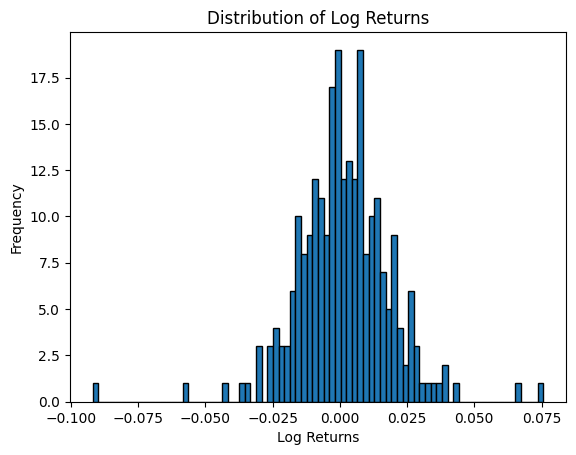

In [79]:
import matplotlib.pyplot as plt

# Plot histogram of log returns
plt.hist(log_returns_arr, bins=80, edgecolor='black')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

The bimodal distribution observed in the log returns suggests volatility clustering, where the market exhibits frequent up or down movements, with fewer instances of no change. This non-linear behavior makes it challenging to use such features effectively in linear regression, as the model assumes a linear relationship between variables. The two peaks around zero highlight the market’s preference to shift rather than remain flat, reflecting non-stationary behavior. Also the data is shifted to the right slightly because stocks in general return positive returns over long time frames.